In [38]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)

In [39]:
df = pd.read_csv('loan_expanded.csv')
print("Data Shape:: ", df.shape)
print("DataSet Length:: ", len(df))

Data Shape::  (500, 8)
DataSet Length::  500


In [40]:
X = df.drop(columns=['loan_status', 'credit_score'])
Y = df['loan_status']

In [41]:
X_processed = pd.get_dummies(X, drop_first=True)
X_train_columns = X_processed.columns

# Encode Target Variable (Y)
le_y = LabelEncoder()
Y_encoded = le_y.fit_transform(Y)
class_names = list(le_y.classes_) 

print("Encoded classes:", le_y.classes_)

# Split Data
X_train, X_test, Y_train, Y_test = train_test_split(
    X_processed, Y_encoded, test_size=0.2, random_state=42
)

# Standardize Numerical Features (Optional for XGBoost, but kept for consistency)
scaler = StandardScaler()
X_train = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train_columns,
    index=X_train.index
)
X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train_columns,
    index=X_test.index
)

Encoded classes: ['Approved' 'Denied']


In [42]:
print("\n" + "="*50)
print("INITIALIZING AND TRAINING XGBOOST MODEL")
print("="*50)


model = xgb.XGBClassifier(
    objective='binary:logistic', 
    random_state=42, 
    n_estimators=300,            
    learning_rate=0.1,           
    max_depth=5,                 
    min_child_weight=20,             
    eval_metric='logloss'
)

model.fit(X_train, Y_train)


# --- 4. Cross-Validation (Initial Check) ---
scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='accuracy')
print("\n--- 5-Fold Cross-Validation Scores ---")
print(f"Mean CV Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

# --- 5. Prediction and Evaluation ---
Y_pred = model.predict(X_test)


INITIALIZING AND TRAINING XGBOOST MODEL

--- 5-Fold Cross-Validation Scores ---
Mean CV Accuracy: 0.9700
Standard Deviation: 0.0170


In [43]:

def evaluate_model(model, X, Y, set_name):
    """Calculates and plots Confusion Matrix and prints evaluation metrics."""
    
    Y_pred = model.predict(X)
    
    cm = confusion_matrix(Y, Y_pred)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Denied', 'Approved'])
    
    plt.figure(figsize=(6, 6))
    cm_disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {set_name}')
    plt.show() 

    
    print(f"\n--- Model Evaluation Metrics ({set_name}) ---")
    
    print("Accuracy = " + str(np.round(accuracy_score(Y, Y_pred), 4)))
    print("Precision = " + str(np.round(precision_score(Y, Y_pred), 4)))
    print("Recall = " + str(np.round(recall_score(Y, Y_pred), 4)))
    print("F1 Score = " + str(np.round(f1_score(Y, Y_pred), 4)))

<Figure size 600x600 with 0 Axes>

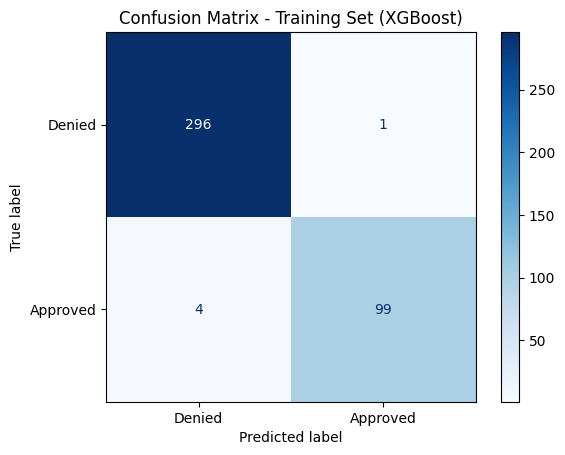


--- Model Evaluation Metrics (Training Set (XGBoost)) ---
Accuracy = 0.9875
Precision = 0.99
Recall = 0.9612
F1 Score = 0.9754


<Figure size 600x600 with 0 Axes>

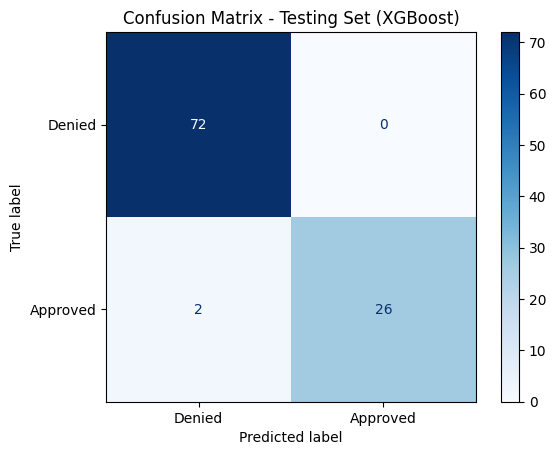


--- Model Evaluation Metrics (Testing Set (XGBoost)) ---
Accuracy = 0.98
Precision = 1.0
Recall = 0.9286
F1 Score = 0.963


In [44]:
# Evaluate Training Set
evaluate_model(model, X_train, Y_train, "Training Set (XGBoost)")

# Evaluate Testing Set
evaluate_model(model, X_test, Y_test, "Testing Set (XGBoost)")

In [47]:
def get_applicant_input():
    
    
   
    valid_genders = ['Male', 'Female']
    valid_occupations = ['Software Engineer', 'Teacher', 'Doctor', 'Sales', 'Other']
    valid_education = ["Bachelor", "Master", 'High School', 'PhD']
    valid_marital = ['Married', 'Single', 'Divorced']

    print("\n--- Enter Applicant Details ---")
    
   
    while True:
        try:
            age = float(input("Age (e.g., 35): "))
            income = float(input("Annual Income (e.g., 55000.00): $"))
            credit_score = float(input("Credit Score (e.g., 720): "))
            if age > 0 and income >= 0 and credit_score >= 300:
                break
            else:
                print("Invalid input. Age must be positive, Income must be non-negative, and Credit Score must be realistic.")
        except ValueError:
            print("Invalid number entered. Please try again.")

  
    print(f"\nValid Genders: {valid_genders}")
    while True:
        gender = input("Gender: ").strip()
        if gender in valid_genders: break
        print("Invalid gender. Please choose from the list.")

    print(f"\nValid Occupations: {valid_occupations}")
    while True:
        occupation = input("Occupation: ").strip()
        if occupation in valid_occupations: break
        print("Invalid occupation. Please choose from the list.")

    print(f"\nValid Education Levels: {valid_education}")
    while True:
        education_level = input("Education Level: ").strip()
        if education_level in valid_education: break
        print("Invalid education. Please choose from the list.")

    print(f"\nValid Marital Statuses: {valid_marital}")
    while True:
        marital_status = input("Marital Status: ").strip()
        if marital_status in valid_marital: break
        print("Invalid marital status. Please choose from the list.")
    
    return age, gender, occupation, education_level, marital_status, income, credit_score


def interactive_test_applicant(model, scaler, X_train_columns):
    
    age, gender, occupation, education_level, marital_status, income, credit_score = get_applicant_input()

    applicant_data = {
        'age': age,
        'gender': gender,
        'occupation': occupation,
        'education_level': education_level,
        'marital_status': marital_status,
        'income': income,
        'credit_score': credit_score
    }

    applicant_df = pd.DataFrame([applicant_data])


    applicant_processed = pd.get_dummies(applicant_df, drop_first=True)
    

    applicant_processed = applicant_processed.reindex(columns=X_train_columns, fill_value=0)

  
    applicant_scaled = pd.DataFrame(
        scaler.transform(applicant_processed),
        columns=applicant_processed.columns
    )

   
    prediction = model.predict(applicant_scaled)[0] 


    print(f"\n{'='*60}")
    print(f"LOAN APPLICATION RESULT (XGBoost)")
    print(f"{'='*60}")
    print(f"Applicant Details:")
    print(f"  - Income: ${income:,.2f}")
    print(f"  - Credit Score: {credit_score}")
    print(f"  - Age: {age}, Gender: {gender}")
    print(f"  - Education: {education_level}, Status: {marital_status}")
    print(f"{'-'*60}")

    result_text = "LOAN APPROVED - Low risk applicant" if prediction == 0 else "LOAN DENIED - High risk applicant"
    print(result_text)
    print(f"{'='*60}\n")

    return prediction



print("\n" + "="*50)
print("STARTING INTERACTIVE APPLICANT TEST")
print("="*50)


interactive_test_applicant(model, scaler, X_train_columns)


STARTING INTERACTIVE APPLICANT TEST

--- Enter Applicant Details ---

Valid Genders: ['Male', 'Female']

Valid Occupations: ['Software Engineer', 'Teacher', 'Doctor', 'Sales', 'Other']

Valid Education Levels: ['Bachelor', 'Master', 'High School', 'PhD']

Valid Marital Statuses: ['Married', 'Single', 'Divorced']

LOAN APPLICATION RESULT (XGBoost)
Applicant Details:
  - Income: $120,000.00
  - Credit Score: 803.0
  - Age: 22.0, Gender: Male
  - Education: Bachelor, Status: Single
------------------------------------------------------------
LOAN APPROVED - Low risk applicant



np.int64(0)

In [46]:
# --- Final Metrics Summary ---
final_acc = accuracy_score(y_true= Y_test, y_pred = Y_pred)
final_f1 = f1_score (y_true=Y_test, y_pred=Y_pred, average="weighted")

print("="*50)
print(f"FINAL TESTING SET PERFORMANCE (XGBoost)")
print("="*50)
print(f"Accuracy: {final_acc:.4f} ({round(final_acc * 100, 2)}%)")
print(f"F1 Score (Weighted): {final_f1:.4f}")
print("="*50)

FINAL TESTING SET PERFORMANCE (XGBoost)
Accuracy: 0.9800 (98.0%)
F1 Score (Weighted): 0.9798
